In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import datetime as dt

%matplotlib inline

In [2]:
dataset = ffn.get("es=f:Open,es=f:High,es=f:Low,es=f:Close", start='2000-01-01')
dataset.rename(columns={"esfopen": "Open",
                        "esfhigh": "High",
                        "esflow": "Low",
                        "esfclose": "Close"}, inplace=True)

#drop last row
dataset.drop(dataset.tail(1).index, axis=0, inplace=True)
dataset

,Open,High,Low,Close
Date,,,,
2000-09-18,1485.25,1489.75,1462.25,1467.50
2000-09-19,1467.00,1482.75,1466.75,1478.50
2000-09-20,1478.75,1480.50,1450.25,1469.50
2000-09-21,1470.25,1474.00,1455.50,1469.50
2000-09-22,1454.75,1471.00,1436.75,1468.50
...,...,...,...,...
2022-11-10,3757.00,3973.50,3751.50,3961.00
2022-11-11,3973.00,4009.75,3951.00,4000.25
2022-11-14,3984.00,4017.50,3964.00,3966.00


In [3]:
# we don't have nan cells
dataset.isna().value_counts()

Open   High   Low    Close
False  False  False  False    5603
dtype: int64

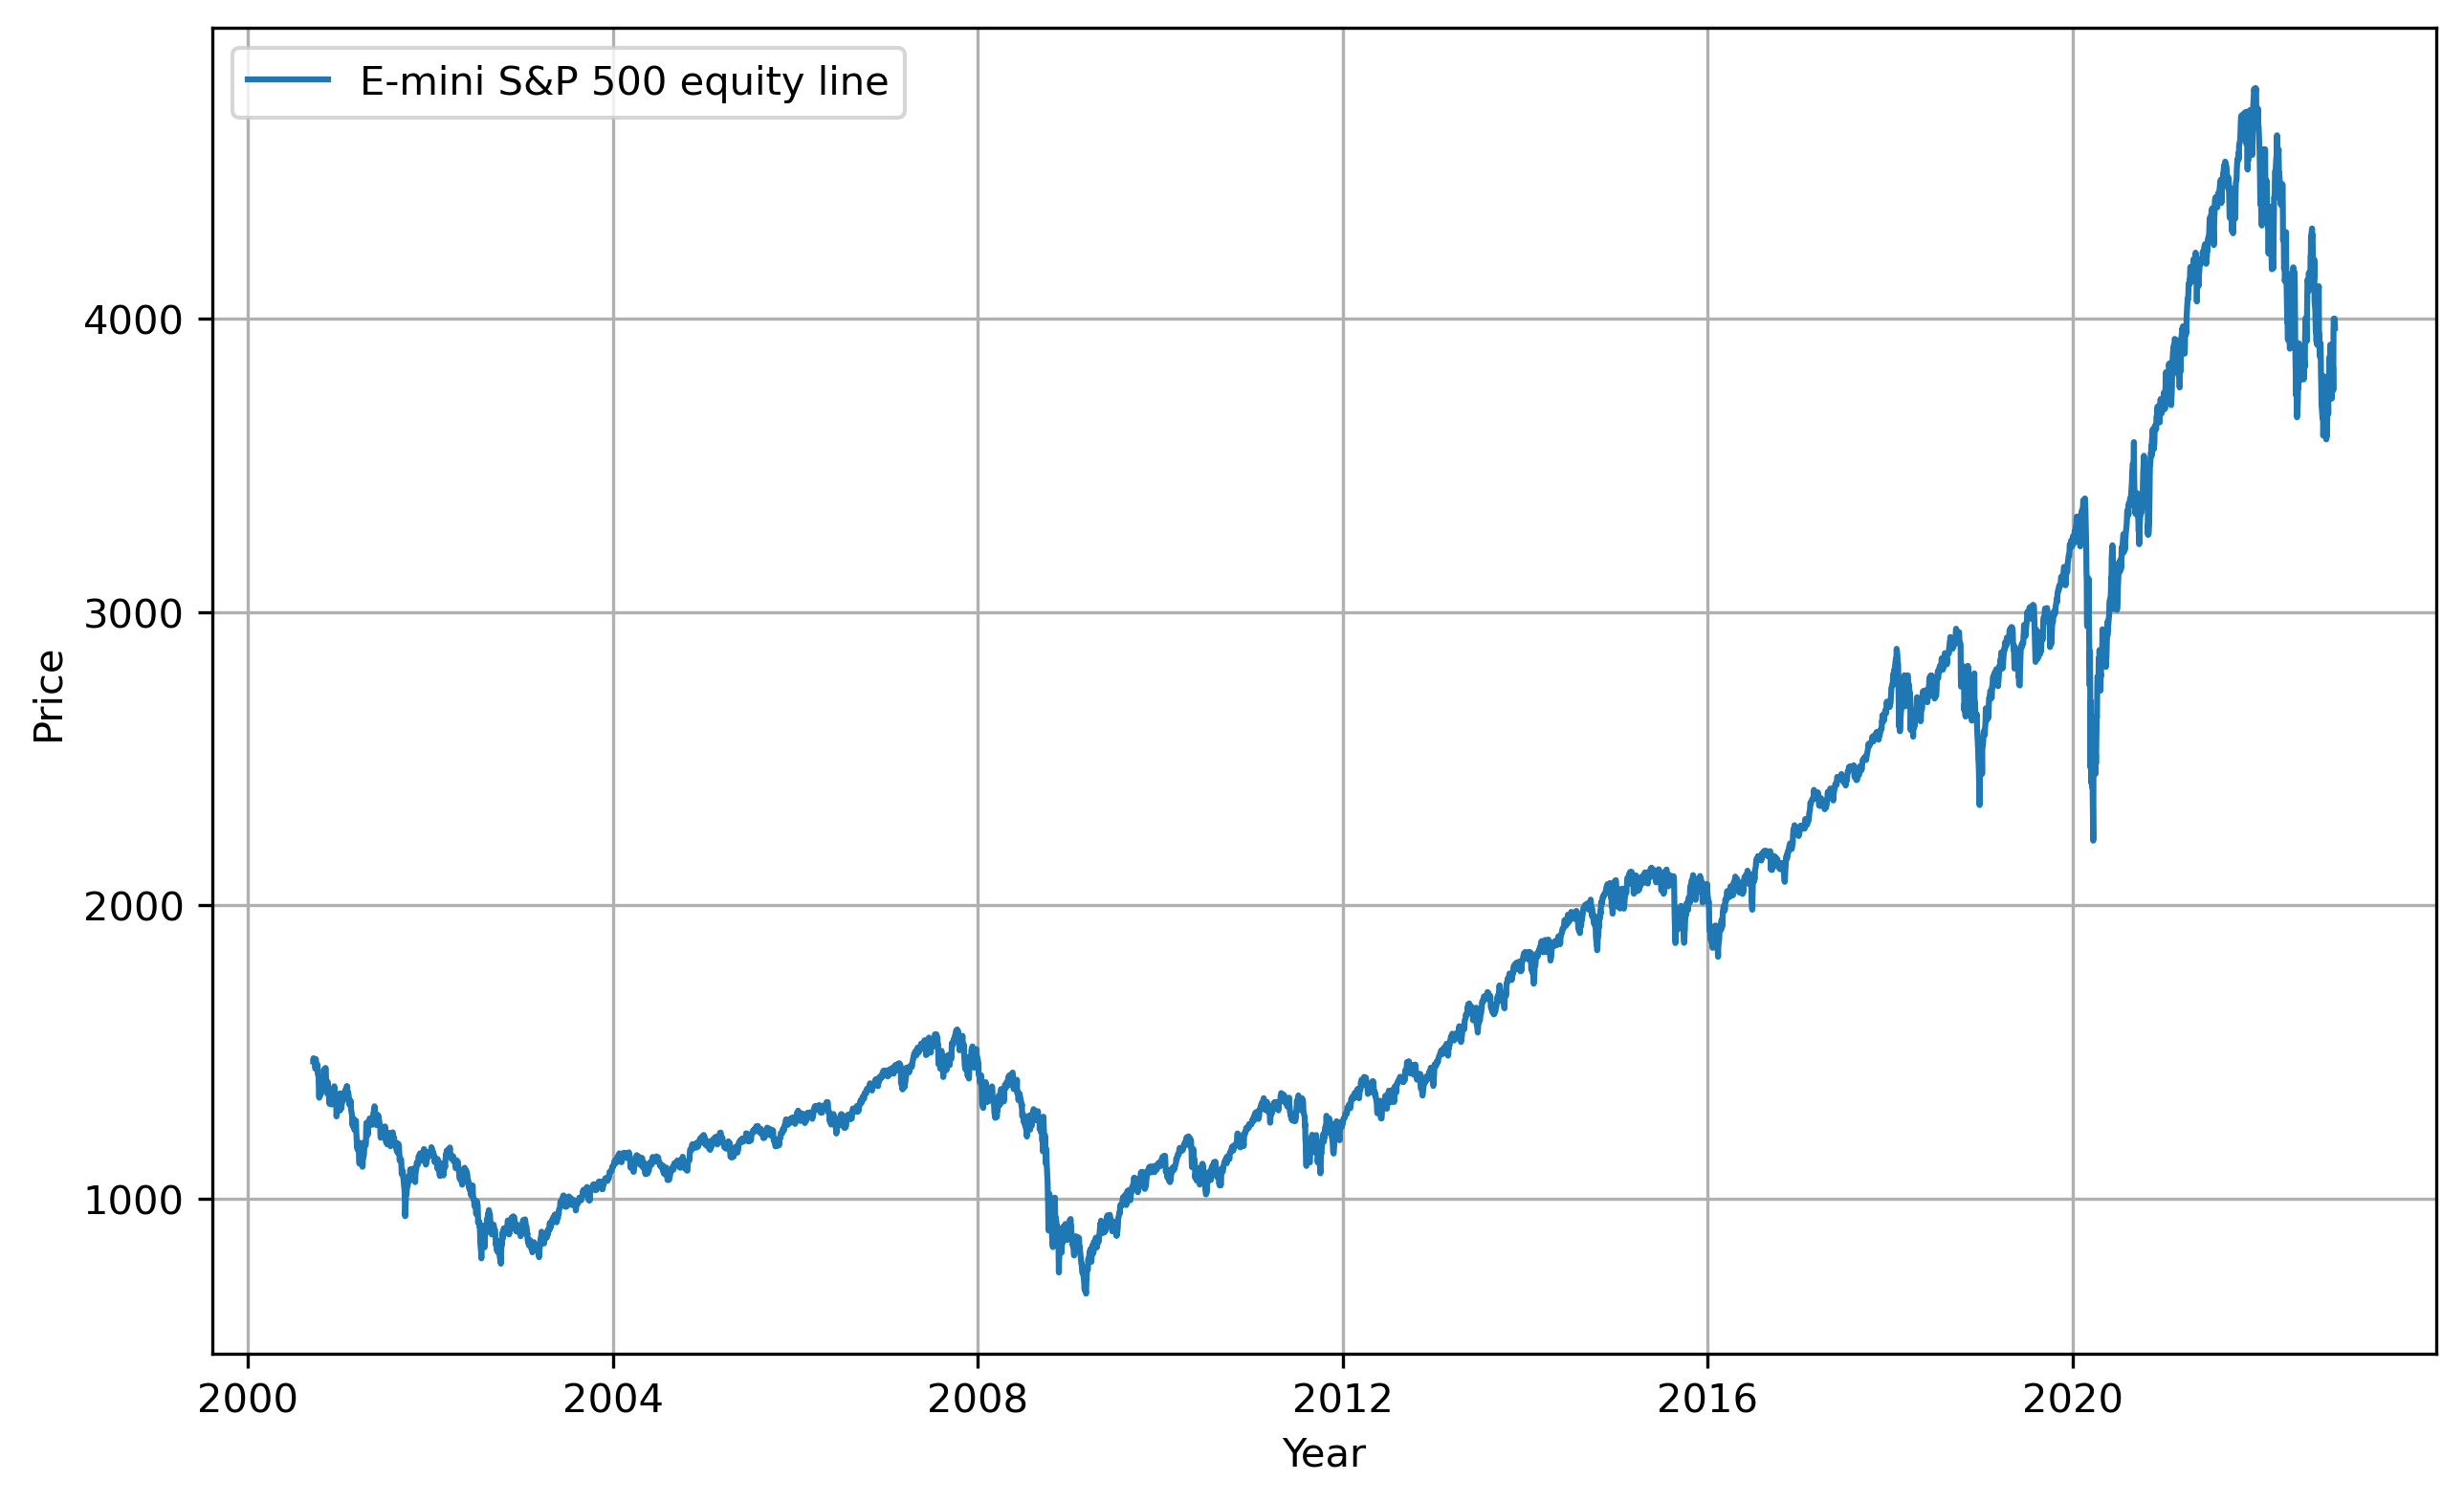

In [4]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(dataset.Close)
plt.legend(["E-mini S&P 500 equity line"])
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()


In [5]:
backtest = pd.DataFrame(dataset[dataset.index.year <= 2019].copy())

    Guadagno e perdita in punti entrando il giorno X e uscendo il giorno Y (tutte le combinazioni):

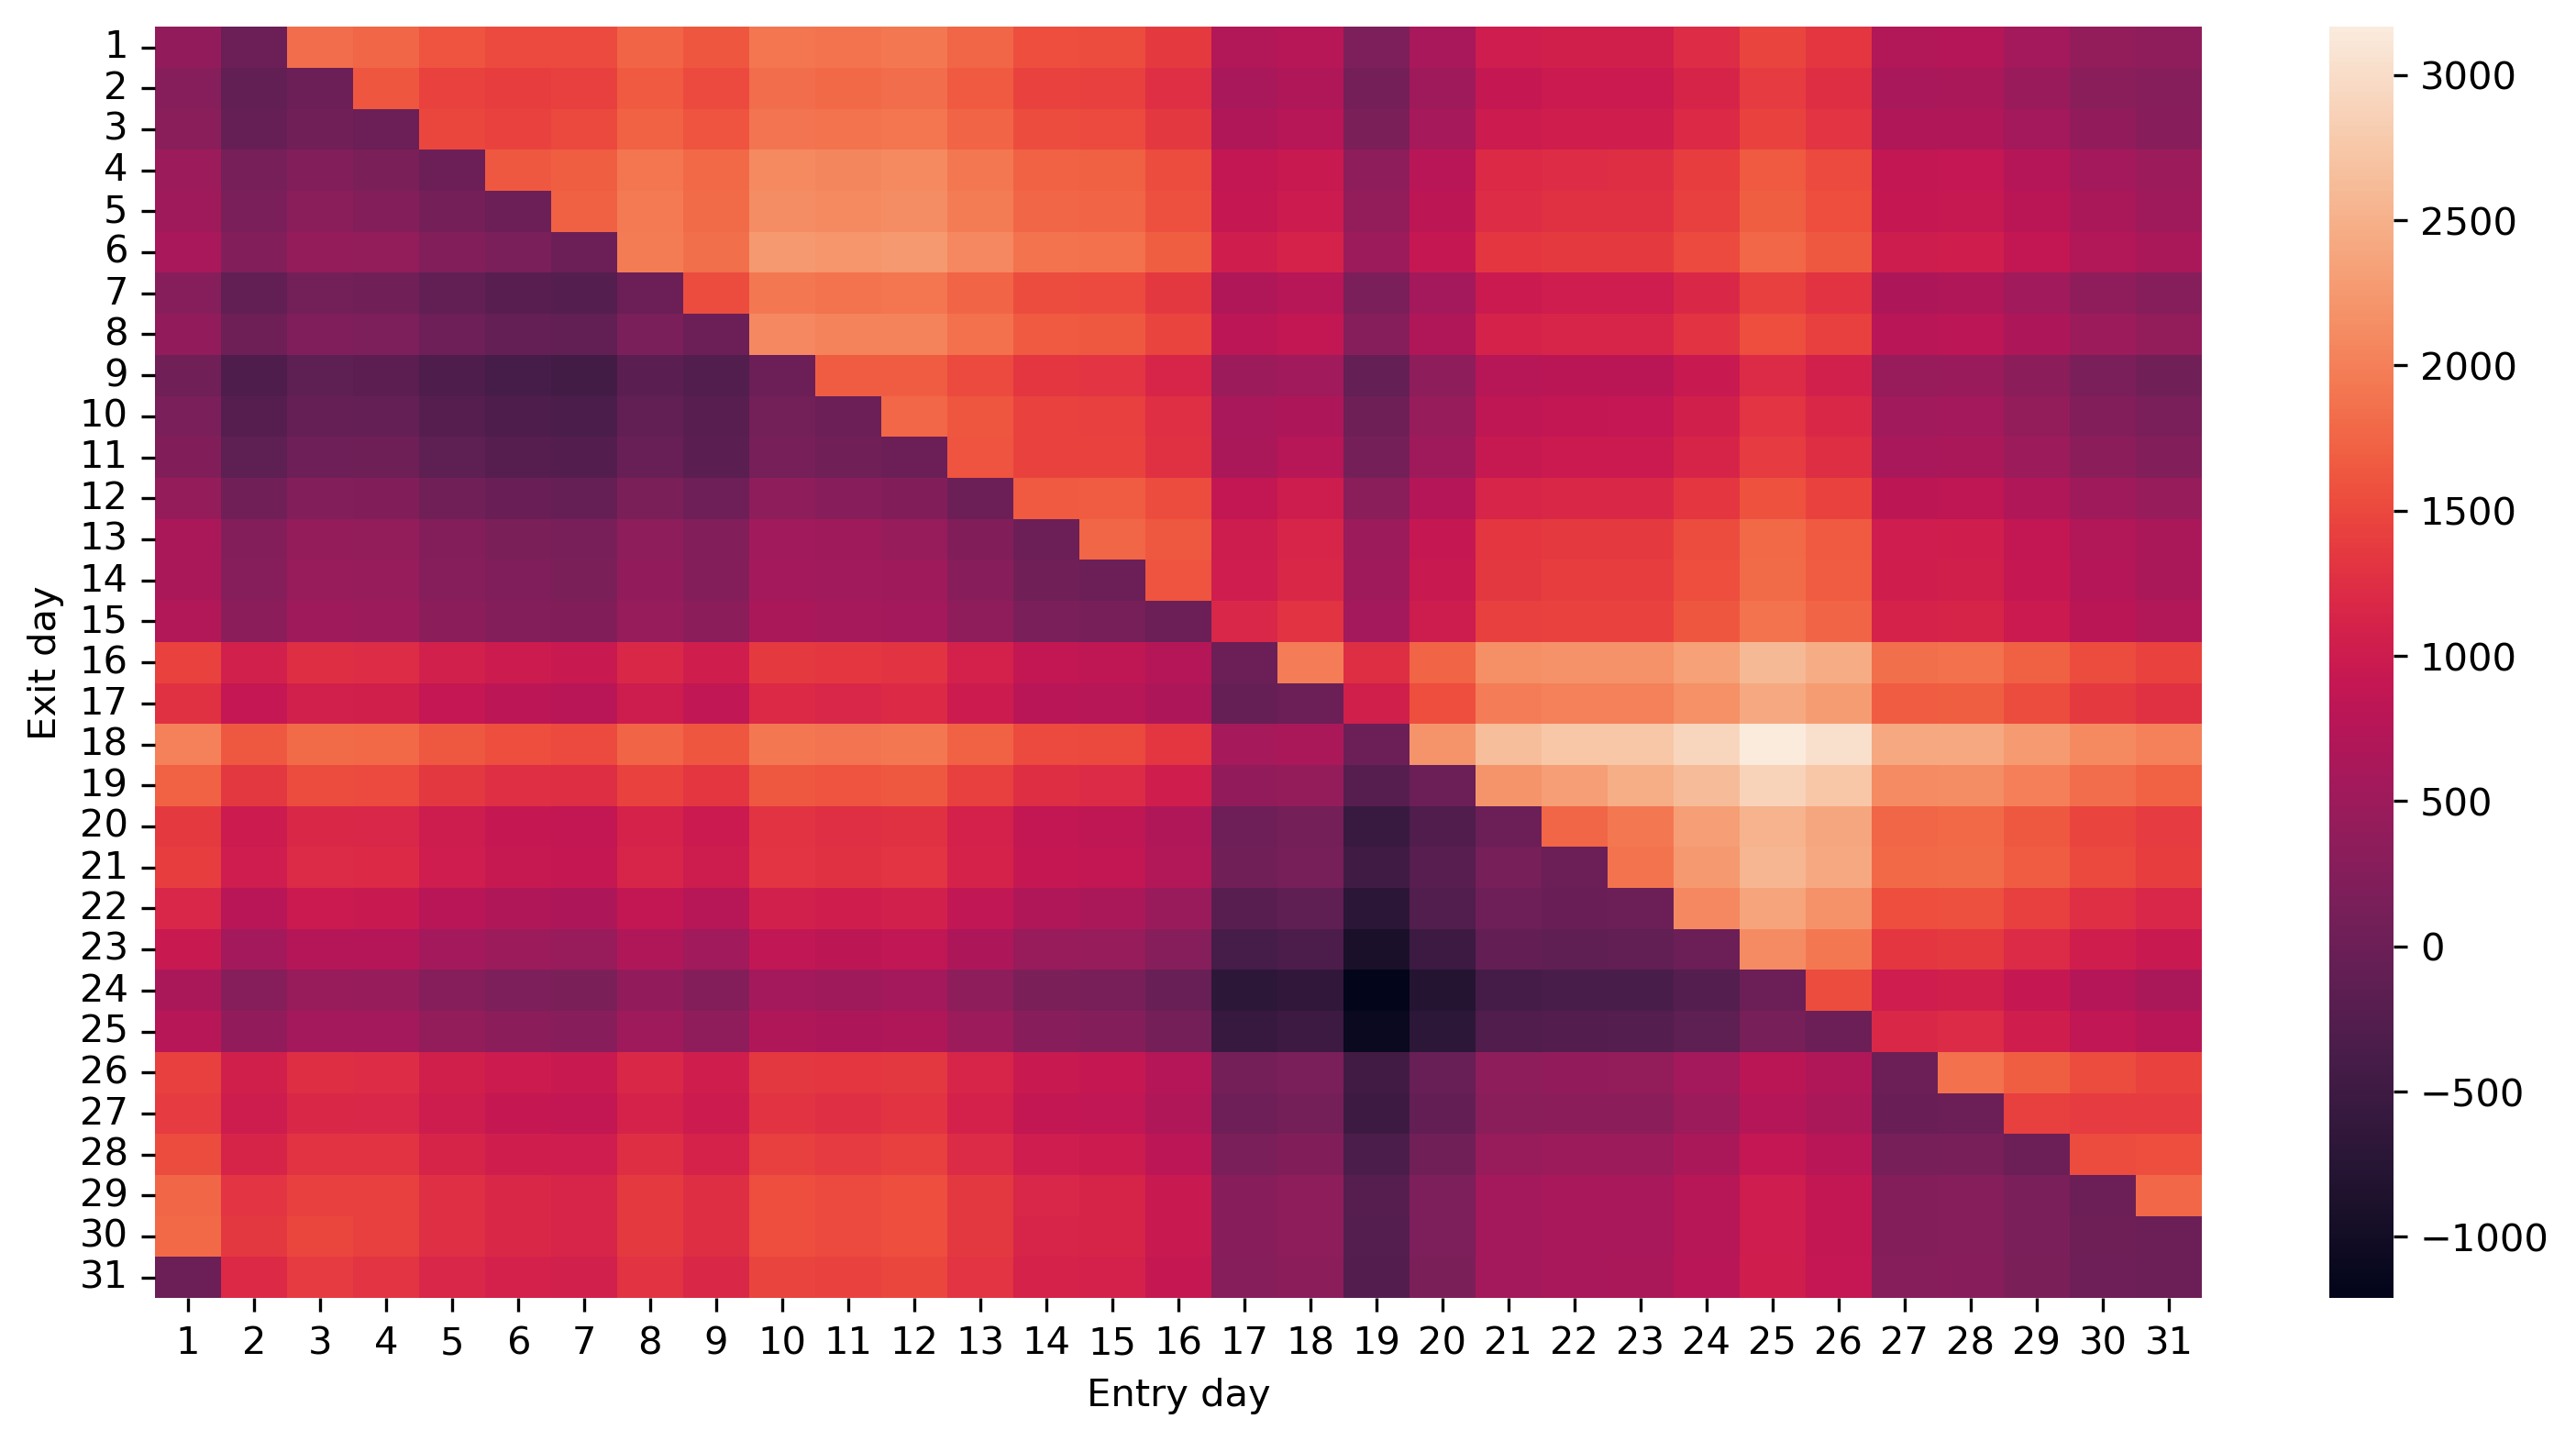

In [6]:
def best_days_to_hold(backtest, var1, var2):
    if var1 <= var2:
        backtest["Mp"] = (backtest.index.day >= var1) & (backtest.index.day <= var2)
    else:
        # ho dei dubbi, ci sono sicuramente delle eccezzioni non gestite
        backtest["Mp"] = (backtest.index.day >= var1) | (backtest.index.day <= var2)    
        
    backtest["Mp"] = backtest["Mp"].apply(lambda x: int(x))
    
    backtest["Entry_price"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), backtest.Open, np.nan)
    backtest.Entry_price = backtest.Entry_price.fillna(method="ffill")
    backtest["Open_operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), 
                                           backtest.Close - backtest.Open,
                                           np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==1),
                                           backtest.Close - backtest.Entry_price, 0))
    backtest["Operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(-1)==0), 
                                      backtest.Open_operations, 0)
    backtest["Closed_equity"] = backtest["Operations"].cumsum().fillna(method="ffill")
    backtest["Open_equity"] = backtest.Closed_equity + backtest.Open_operations
    backtest["Drawdown_points"]= backtest["Closed_equity"].expanding().max() - backtest["Closed_equity"]
    
    return [var1, var2, backtest.Closed_equity[-1], backtest.Drawdown_points.max()]

df = pd.DataFrame(dataset[dataset.index.year <= 2019].copy())
risultati = []
for var1 in range(1, 32):
    for var2 in range(1,32):
        risultati.append(best_days_to_hold(df, var1, var2))
        
risultati=pd.DataFrame(risultati, columns=["Var1", "Var2", "Equity", "Max_dd"])
matrix_equity_results = risultati.pivot("Var1", "Var2", "Equity")
matrix_drawdown_results = risultati.pivot("Var1", "Var2", "Max_dd")
matrix_equity_results.head()
plt.figure(figsize=(12,6), dpi=300)
sns.heatmap(matrix_equity_results.T).set(xlabel="Entry day", ylabel="Exit day");

    La zona più chiara è quella che fa guadagnare più punti. 
    La zona nera va in negativo di punti, quindi li conviene andare short.
    Il fatto che i punti a maggiore profitto e perdita non siano sparsi, ma sono vicini tra di loro formando dei gruppi è un buon segno. Fa sembrare meno una casualità e più un pattern ciclico.

In [7]:
def statistiche_strategia(df):
    n_trade = df.Real_operations.count()
    n_trade_vincenti = df[df.Real_operations >= 0].Real_operations.count()
    n_trade_perdenti = df[df.Real_operations < 0].Real_operations.count()
    guadagno_medio = round(df[df.Real_operations >= 0].Real_operations.mean(),2)
    perdita_media = round(df[df.Real_operations < 0].Real_operations.mean(),2)
    guadagno_medio_per_trade = round(df.Real_operations.mean(),2)
    probabilita_di_profitto = round(n_trade_vincenti / n_trade*100,)
    max_drawdown = df.Real_open_dd.max()
    final_equity=round(df.iloc[-1].Real_closed_equity,2)
    print("")
    print("Final equity:", final_equity, "points")
    print("")
    print("Number of trades:", n_trade)
    print("")
    print("Number of winning trades:", n_trade_vincenti)
    print("Average profit of winning trades:", guadagno_medio, "points")
    print("")
    print("Number of losing trades:", n_trade_perdenti)
    print("Average loss of losing trades:", perdita_media, "points")
    print("")
    print("Average profit per trade:", guadagno_medio_per_trade, "points")
    print("")
    print("Probability of profit: "+str(probabilita_di_profitto)+"%")
    print("")
    print("Max drawdown: ",max_drawdown, "points")
    print("")
    print("")
    return

## Long strategy
    Entry the 25th, exit the 18th of next month:

In [57]:
def draw_equity_line(df, open_or_closed_equity):
    plot_equity = df.Real_closed_equity
    plot_dd = df.Real_closed_dd
    if open_or_closed_equity == "open":
        plot_equity = df.Real_open_equity
        plot_dd = df.Real_open_dd


        
    fig, ax = plt.subplots(2, figsize=(12, 12), dpi=300, sharex=True)
    ax[0].plot(plot_equity, color="green")
    ax[0].axvline(dt.datetime(2020,1,1),color="black")
    ax[0].legend(["Strategy equity line"])
    ax[0].set_ylabel('Points')
    ax[0].grid()
    

    ax[1].fill_between(df.index, 0, -plot_dd, color="red")
    ax[1].axvline(dt.datetime(2020,1,1),color="black")
    ax[1].legend(["Strategy drawdown"], loc="lower left")
    ax[1].set_ylabel('Points')
    ax[1].set_xlabel('Time')
    ax[1].grid()
    plt.subplots_adjust(wspace=0, hspace=0)

    
    
    
    
    return

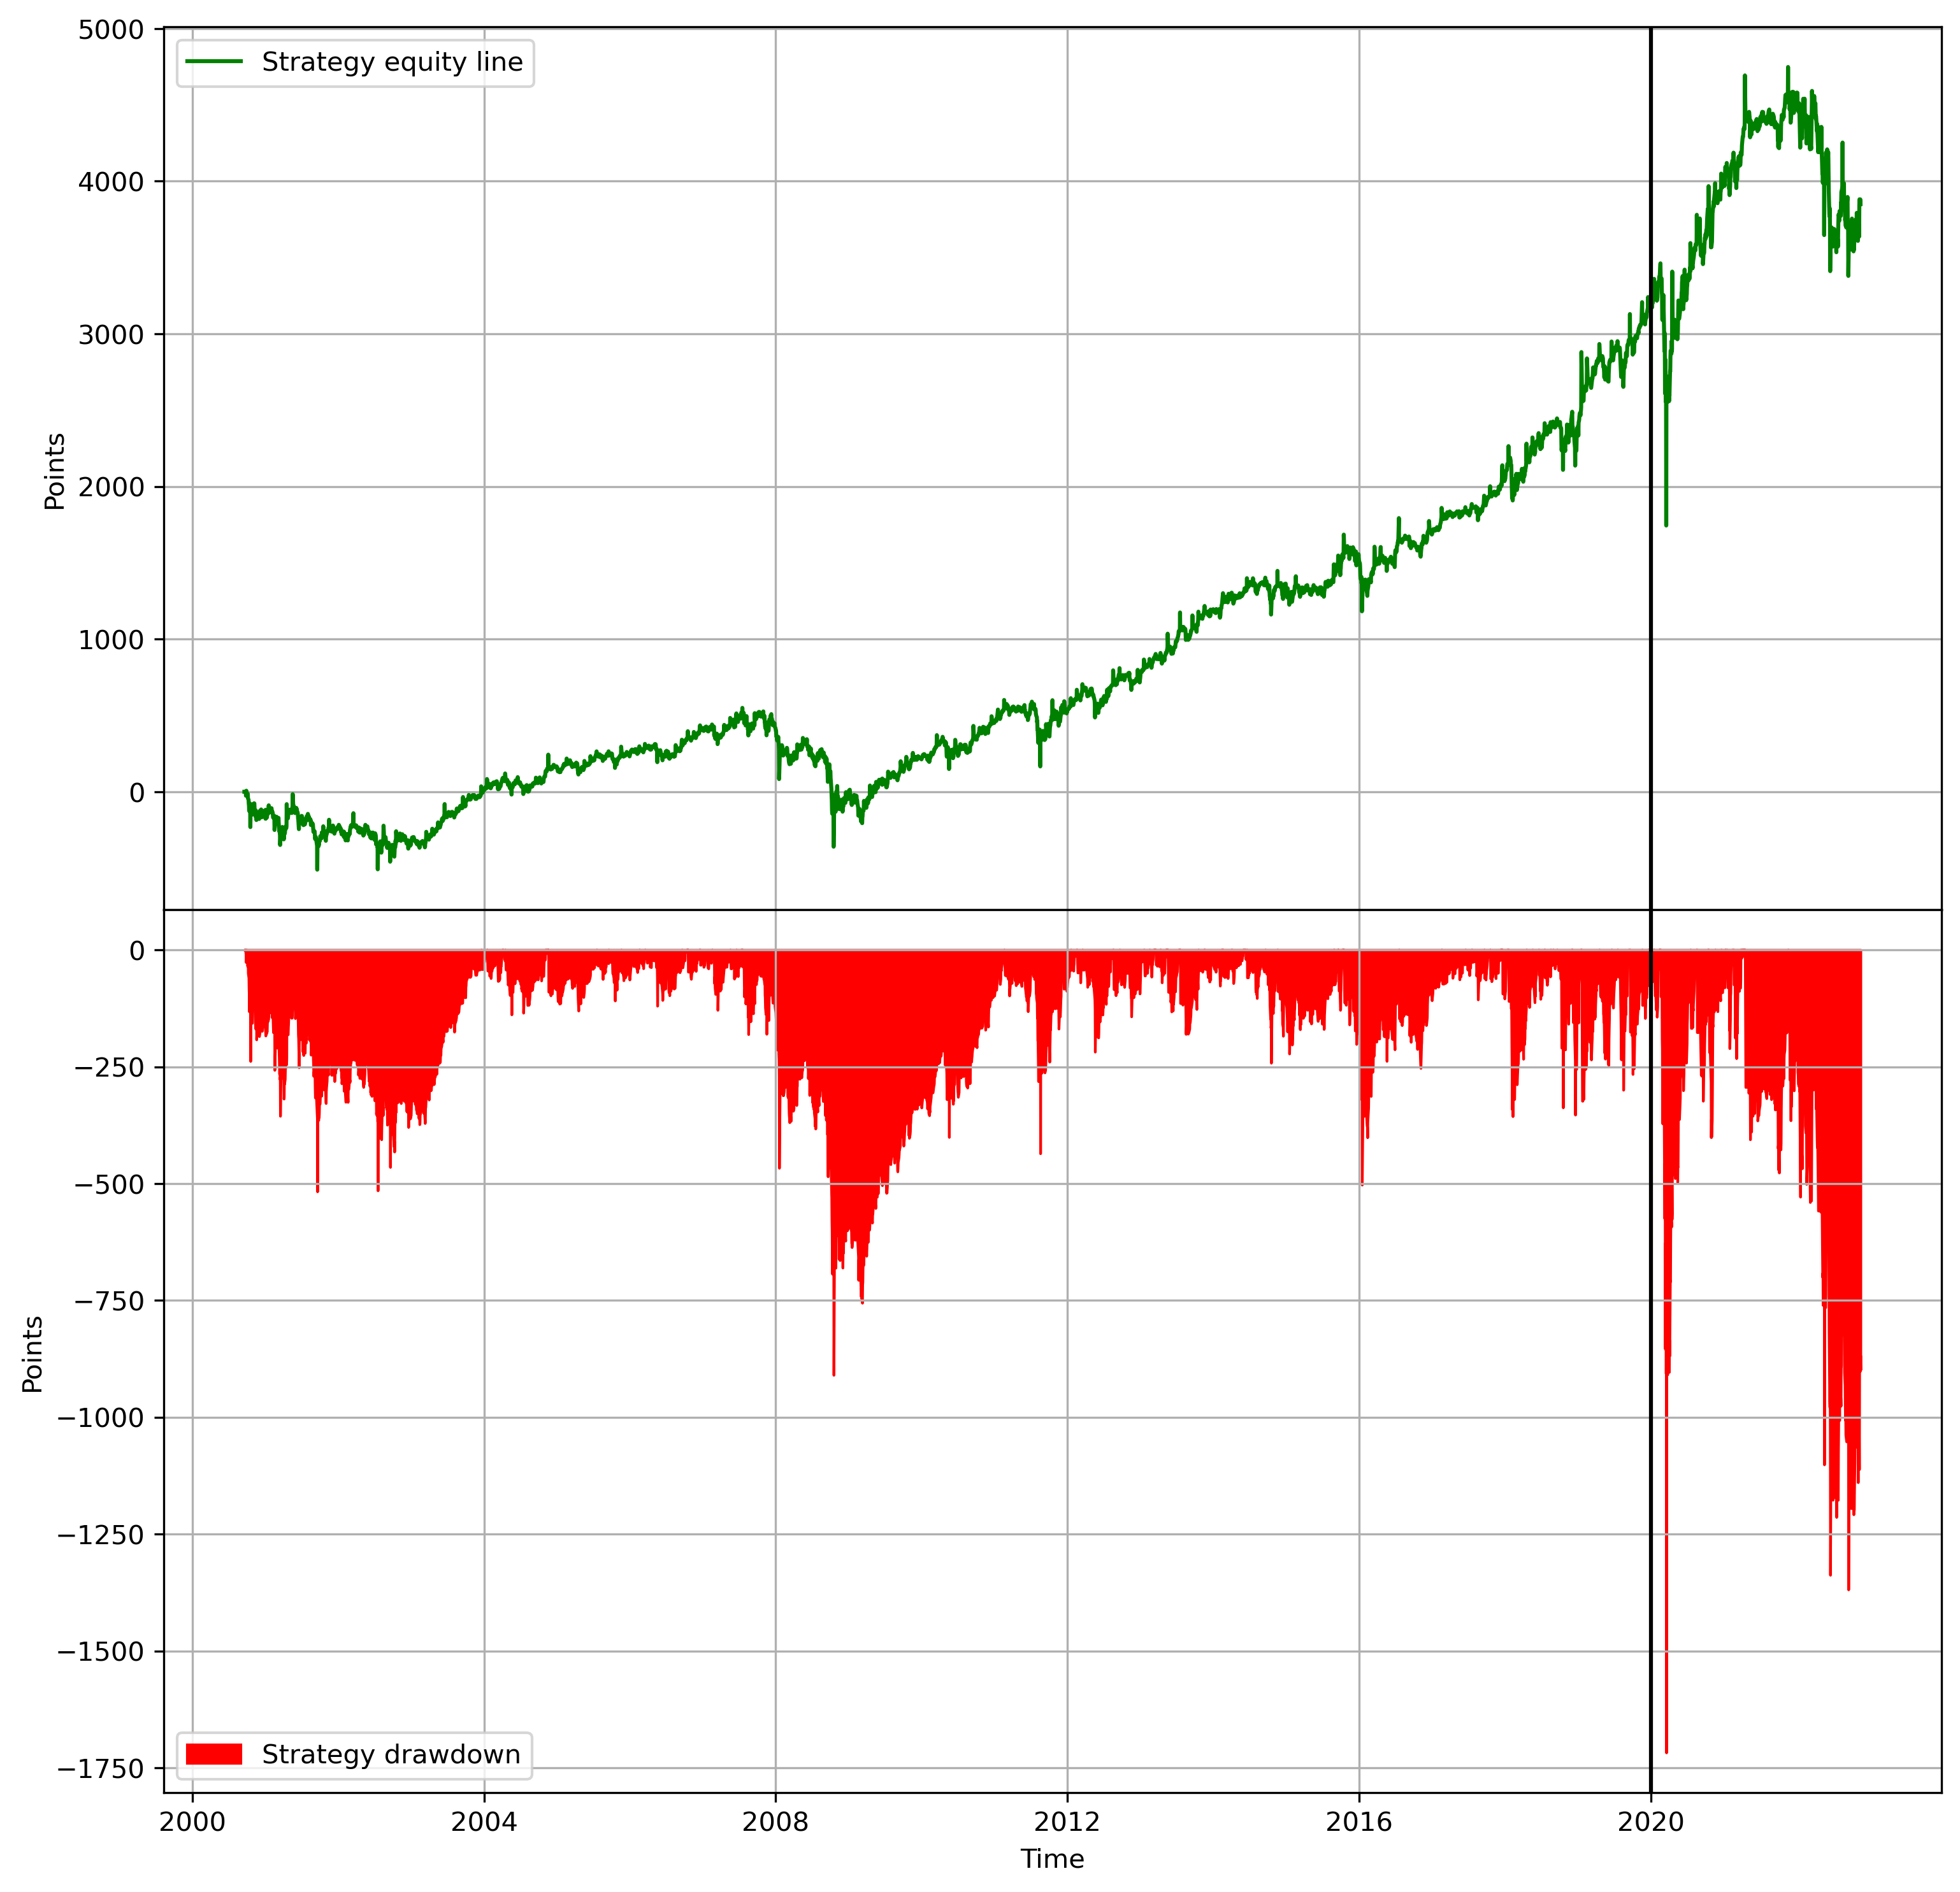

In [58]:
backtest = pd.DataFrame(dataset.copy())
backtest["Mp"] = (backtest.index.day >= 25) | (backtest.index.day <= 18)
#backtest["Mp"] = (backtest.index.day >= 10) & (backtest.index.day <= 18)
backtest["Mp"] = backtest["Mp"].apply(lambda x: int(x))
backtest["Entry_price"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), backtest.Open, np.nan)
backtest.Entry_price = backtest.Entry_price.fillna(method="ffill")
backtest["Open_operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), 
                                       backtest.Close - backtest.Open,
                                       np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==1),
                                       backtest.Close - backtest.Entry_price, 0))
backtest["Real_operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(-1)==0), 
                                  backtest.Open_operations, np.nan)
backtest["Real_closed_equity"] = backtest.Real_operations.cumsum().fillna(method="ffill")
backtest["Real_open_equity"] = backtest.Real_closed_equity + backtest.Open_operations
backtest["Real_open_dd"] = backtest["Real_open_equity"].expanding().max() - backtest["Real_open_equity"]
backtest["Real_closed_dd"]= backtest["Real_closed_equity"].expanding().max() - backtest["Real_closed_equity"]

draw_equity_line(backtest, "open")

In [59]:
statistiche_strategia(backtest)


Final equity: 3684.57 points

Number of trades: 266

Number of winning trades: 176
Average profit of winning trades: 56.12 points

Number of losing trades: 90
Average loss of losing trades: -68.81 points

Average profit per trade: 13.85 points

Probability of profit: 66%

Max drawdown:  1717.5 points




## Short  strategy
    Entrata il 19 e uscita il 24

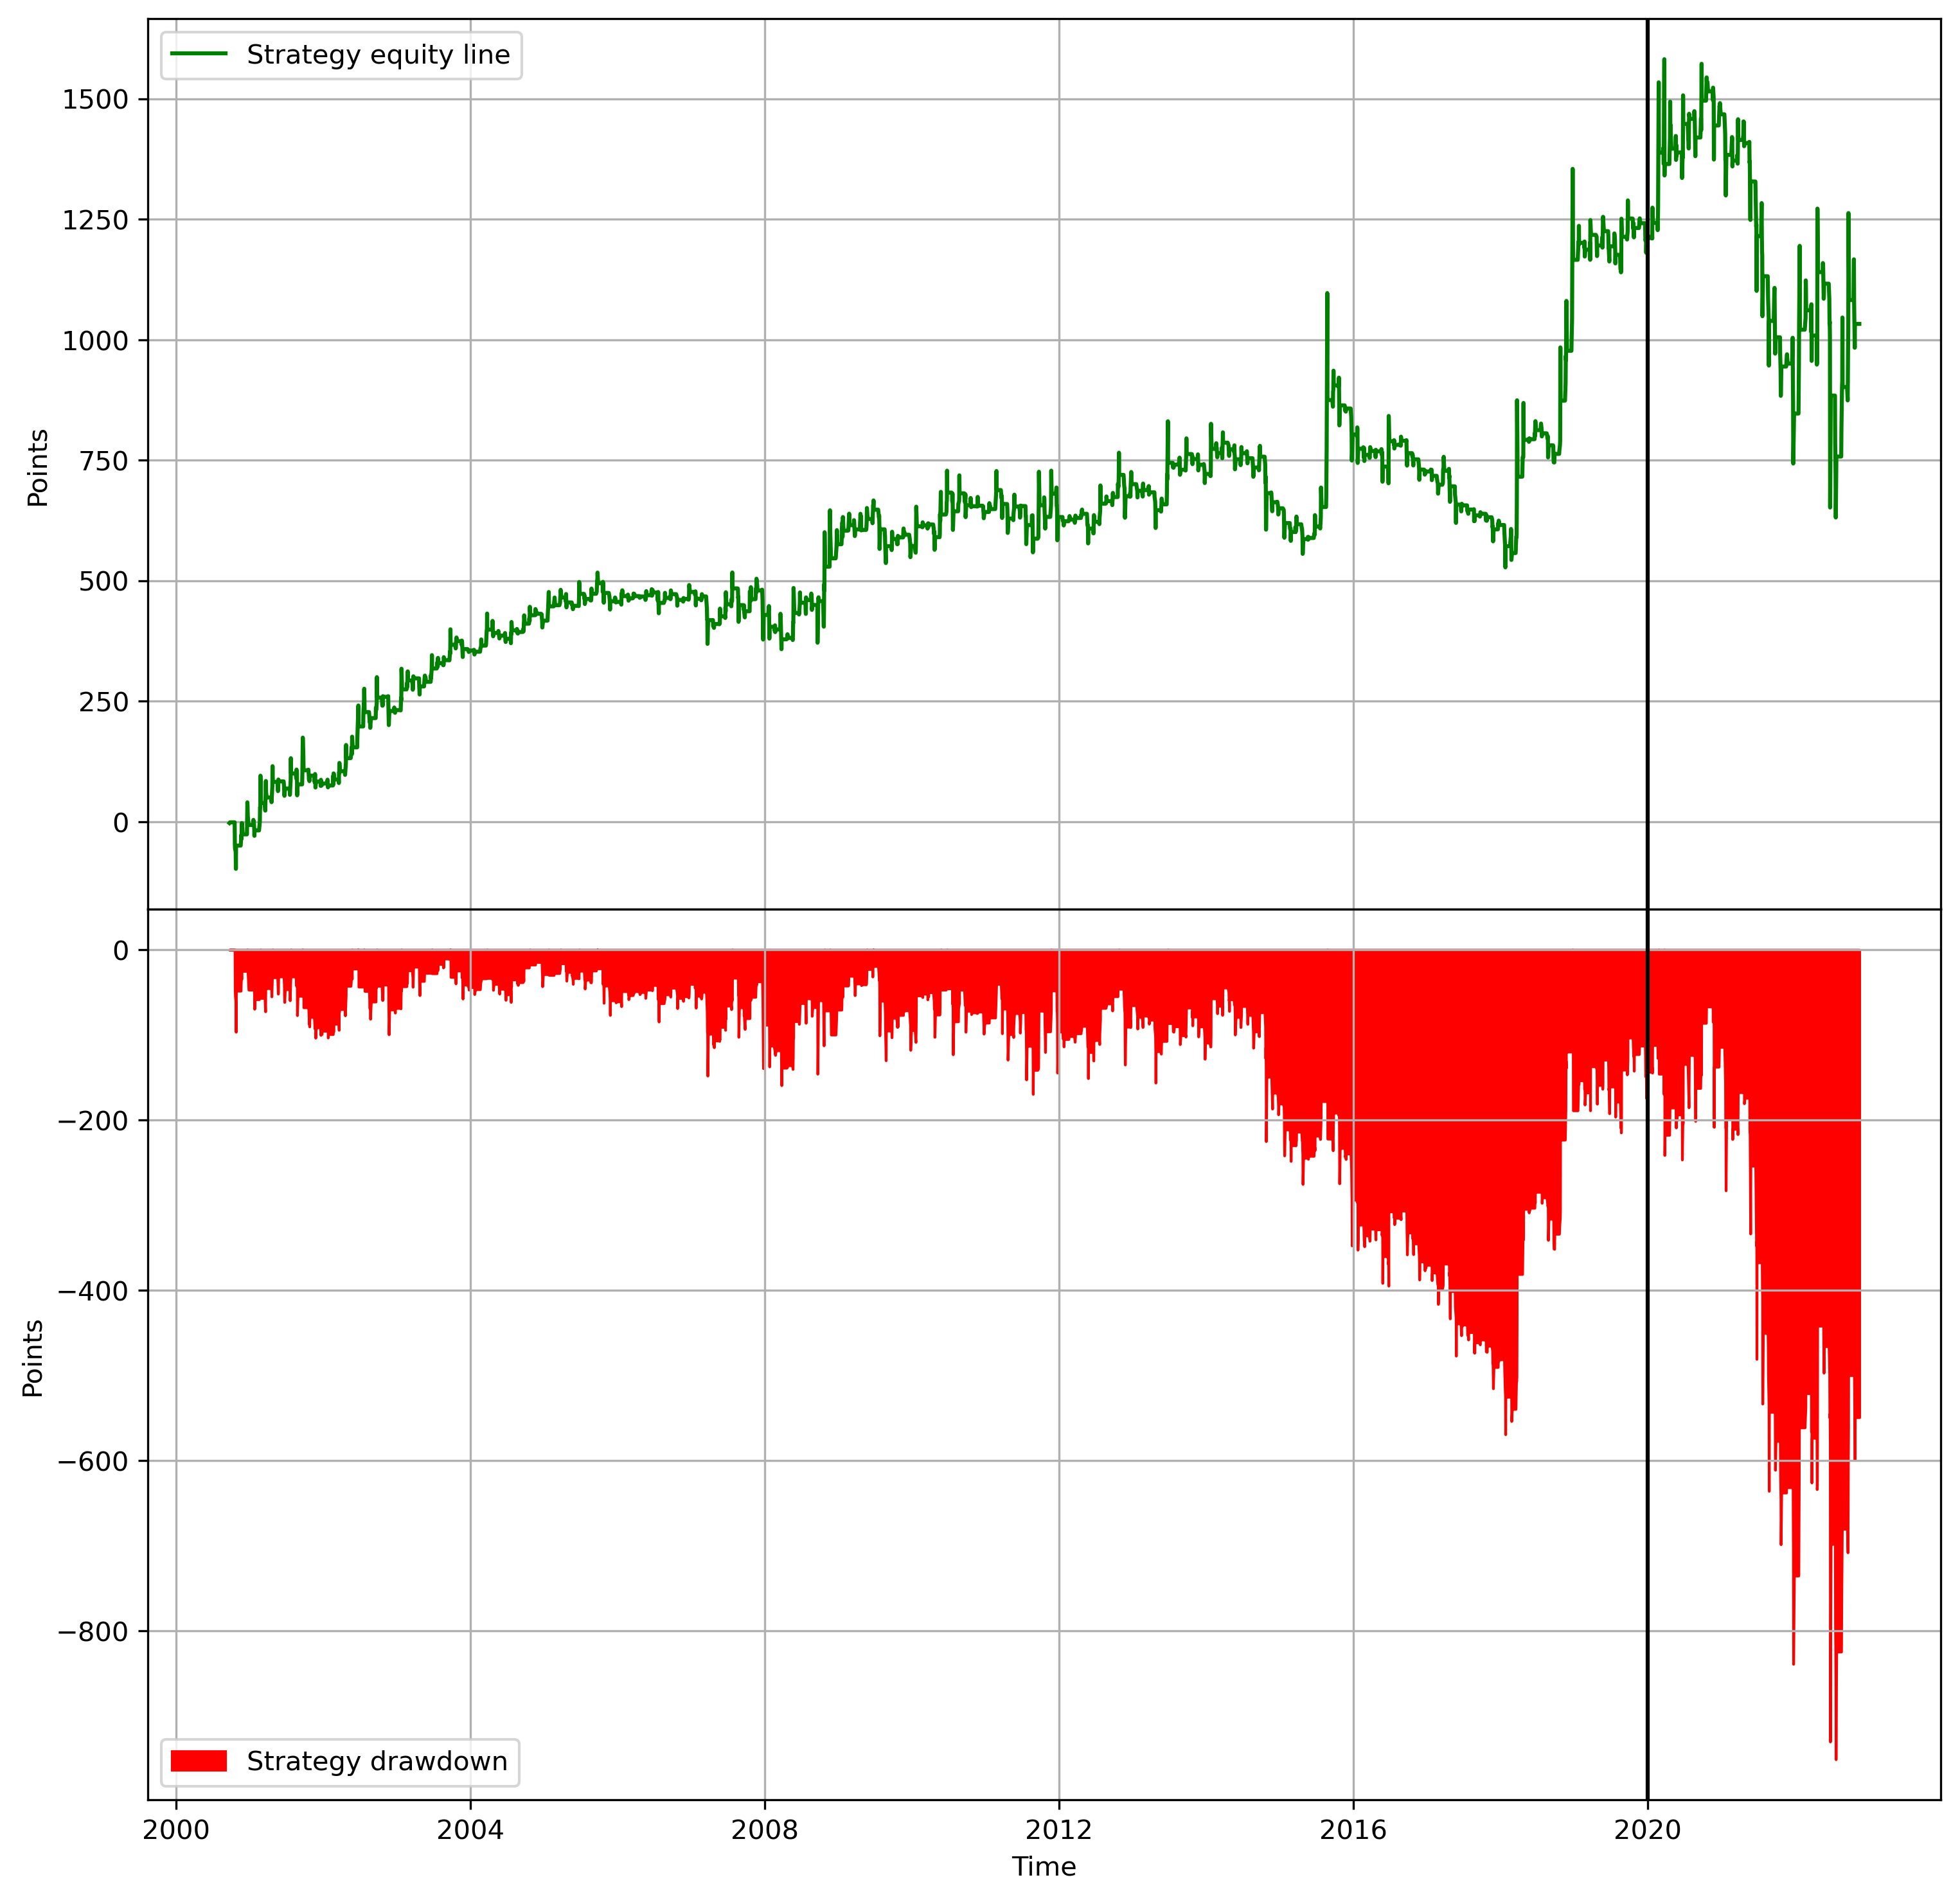

In [60]:
# questo è uno short
backtest["Mp"] = (backtest.index.day >= 19) & (backtest.index.day <= 24)
backtest["Mp"] = backtest["Mp"].apply(lambda x: int(x))
backtest["Entry_price"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), backtest.Open, np.nan)
backtest.Entry_price = backtest.Entry_price.fillna(method="ffill")
backtest["Open_operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), 
                                       - (backtest.Close - backtest.Open),
                                       np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==1),
                                       - (backtest.Close - backtest.Entry_price), 0))
backtest["Real_operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(-1)==0), 
                                  backtest.Open_operations, np.nan)
backtest["Real_closed_equity"] = backtest.Real_operations.cumsum().fillna(method="ffill")
backtest["Real_open_equity"] = backtest.Real_closed_equity + backtest.Open_operations
backtest["Real_open_dd"] = backtest["Real_open_equity"].expanding().max() - backtest["Real_open_equity"]
backtest["Real_closed_dd"]= backtest["Real_closed_equity"].expanding().max() - backtest["Real_closed_equity"]
draw_equity_line(backtest, "open")

In [109]:
statistiche_strategia(backtest)


Final equity: 1034.25 points

Number of trades: 265

Number of winning trades: 137
Average profit of winning trades: 32.29 points

Number of losing trades: 128
Average loss of losing trades: -26.48 points

Average profit per trade: 3.9 points

Probability of profit: 52%

Max drawdown:  951.0 points




    Sia il long che lo short hanno raddoppiato il drawdown nella validazione.
    Ovviamente ciò è dovuto alla volatilità del mercato che come sappiamo è cresciuta negli ultimi anni.
    Dobbiamo usare una forma di protezione da queste fasi di drawdown.

    Feb-mar 2020: perdere 2000 punti in una sola operazione può essere dannoso,
    dobbiamo trovare una forma di protezione migliore.

### Long strategy with stop level

In [61]:
def generate_mp(enter_rules, exit_rules):
    mp=[]
    status=0
    for i,j in zip(enter_rules, exit_rules):
        if i == 1:
            status=1
        if j == 1:
            status=0
        mp.append(status)    
    
    return mp

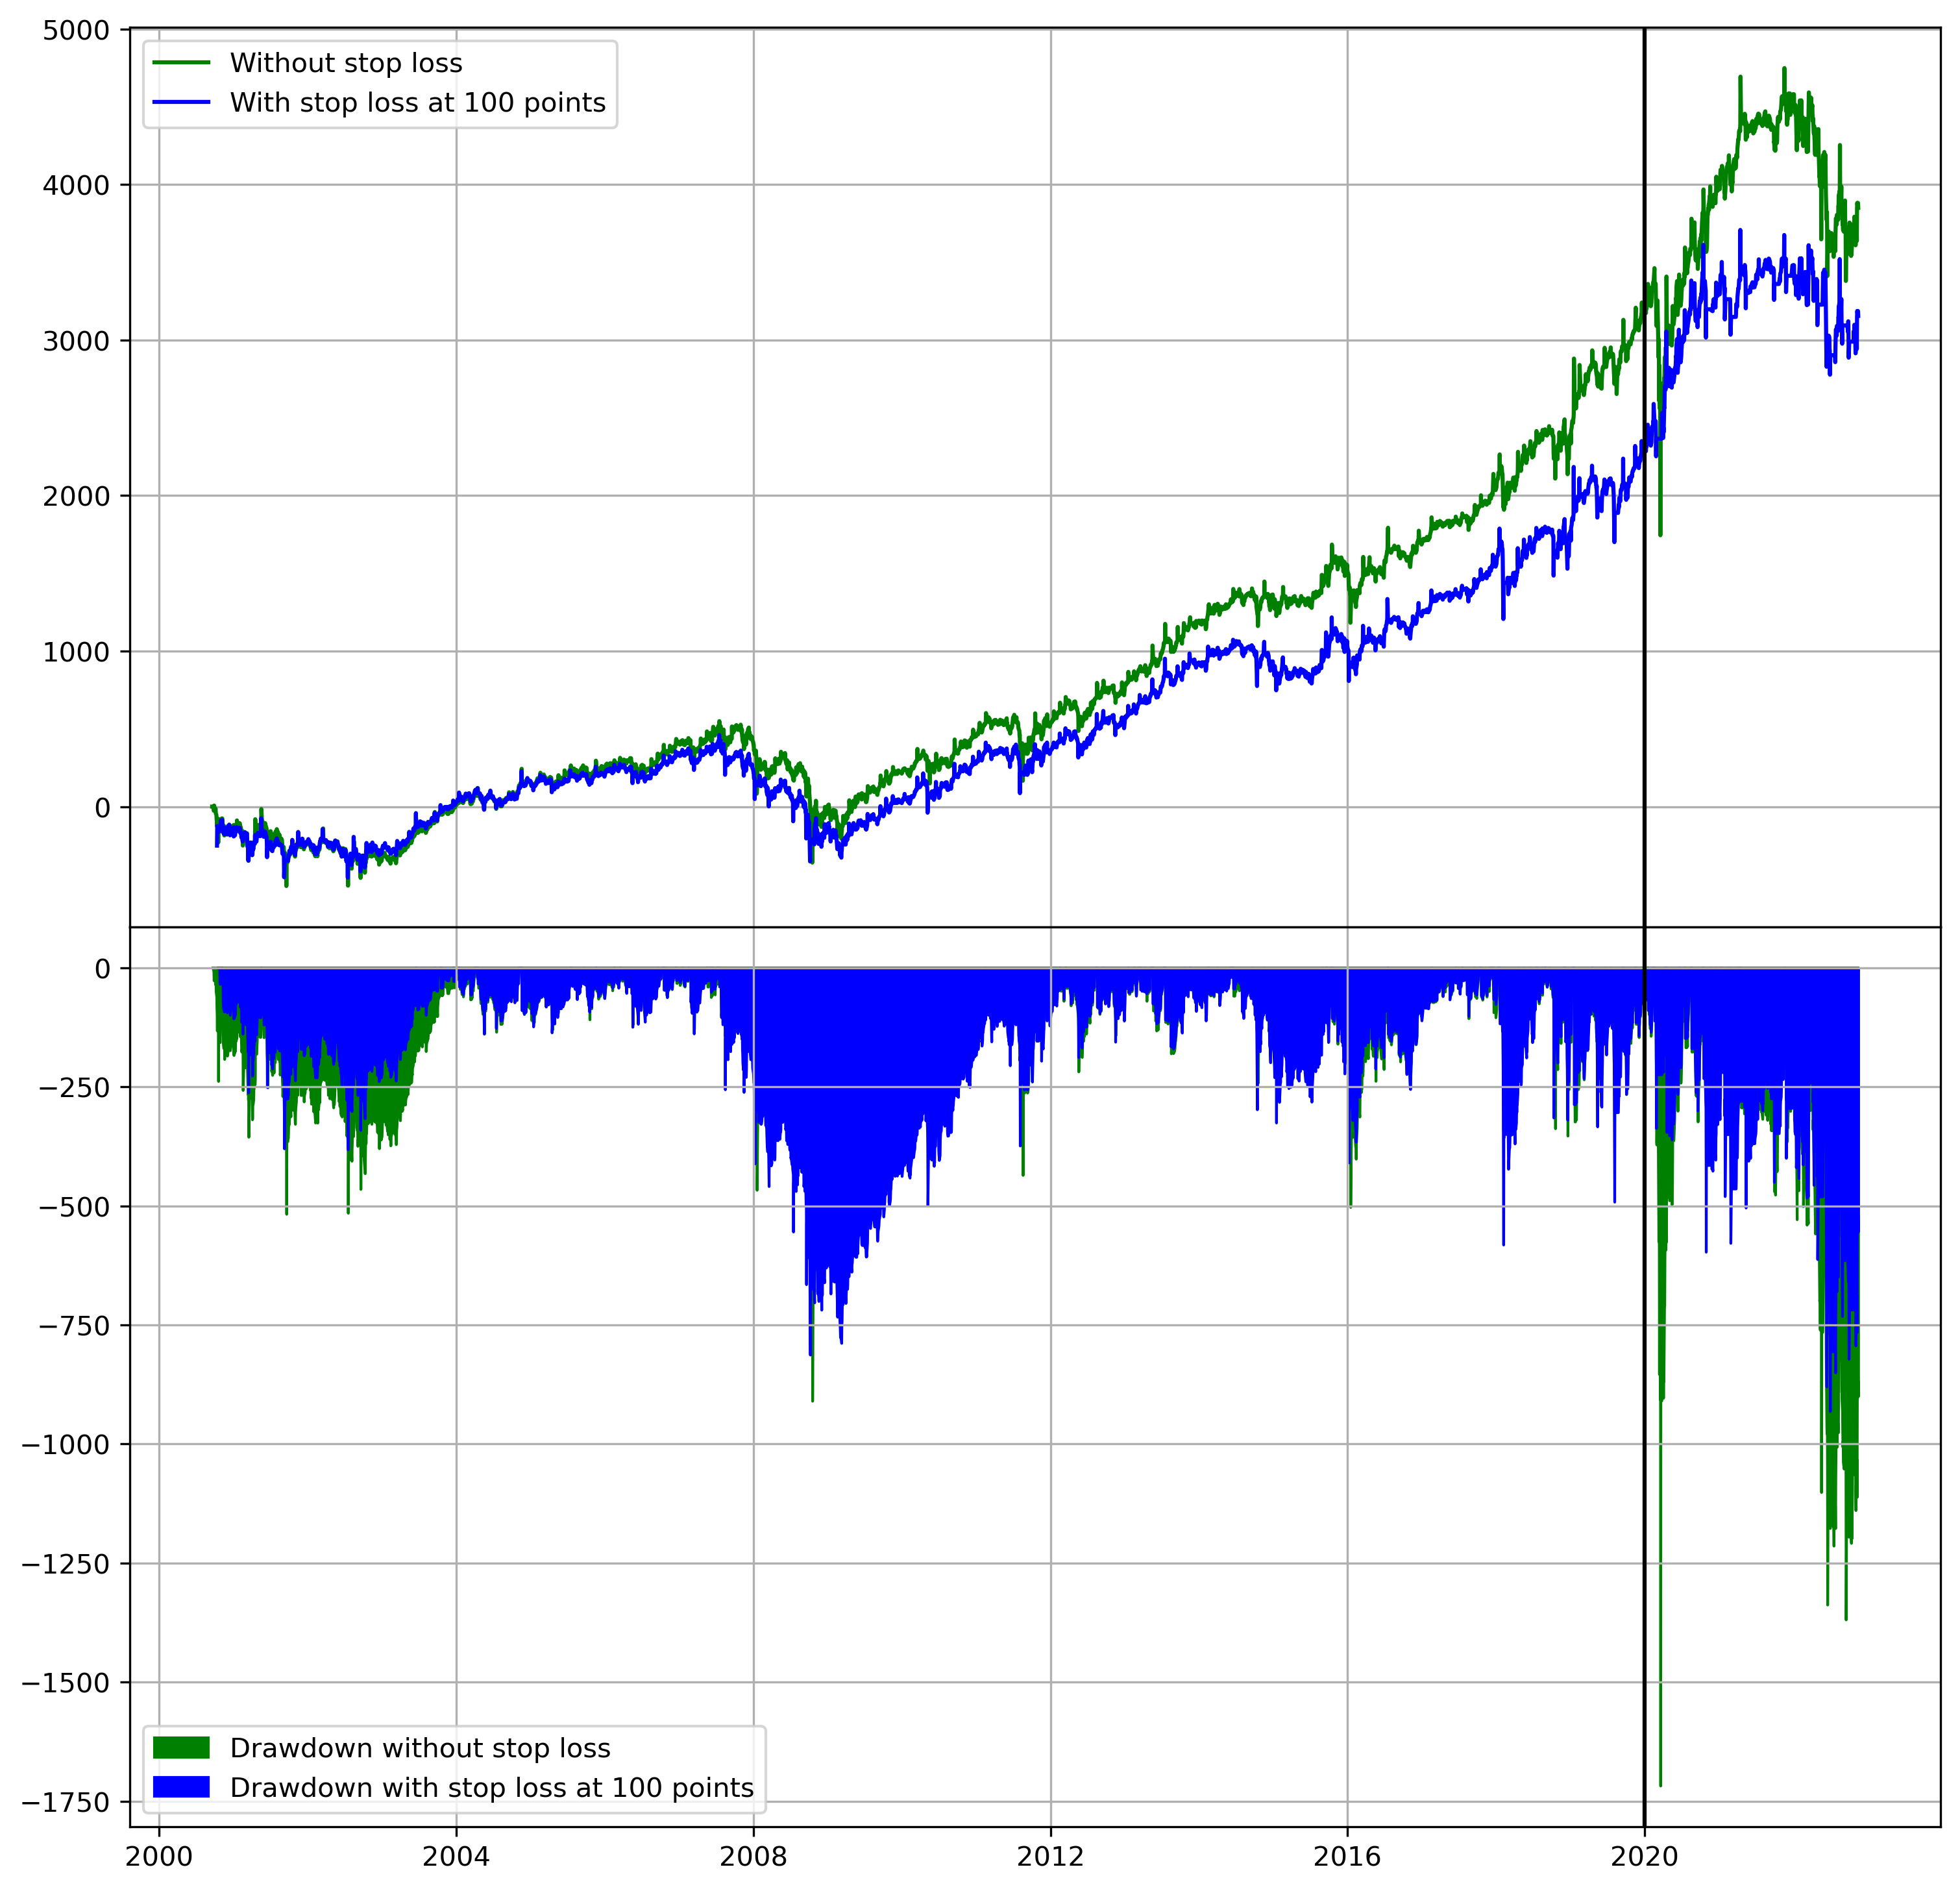

In [63]:
backtest = pd.DataFrame(dataset[dataset.index.year <= 12019].copy())

max_dd_in_point = 100

backtest["Mp"] = (backtest.index.day >= 25) | (backtest.index.day <= 18)
#backtest["Mp"] = (backtest.index.day >= 10) & (backtest.index.day <= 18)
backtest["Mp"] = backtest["Mp"].apply(lambda x: int(x))
backtest["Entry_price"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), backtest.Open, np.nan)
backtest.Entry_price = backtest.Entry_price.fillna(method="ffill")
backtest["Open_operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), 
                                       backtest.Close - backtest.Open,
                                       np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==1),
                                       backtest.Close - backtest.Entry_price, 0))
backtest["Operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(-1)==0), 
                                  backtest.Open_operations, 0)
backtest["Closed_equity"] = backtest.Operations.cumsum().fillna(method="ffill")
backtest["Open_equity"] = backtest.Closed_equity + backtest.Open_operations
backtest["Open_dd"] = backtest["Open_equity"].expanding().max() - backtest["Open_equity"]
backtest["Closed_dd"]= backtest["Closed_equity"].expanding().max() - backtest["Closed_equity"]



real_enter_rules = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1) == 0),1,0)
real_exit_rules = np.where(((backtest.Mp == 1) & (backtest.Mp.shift(-1) == 0))
                                       | ((backtest.Mp == 1) & (backtest.Open_operations.shift(1) < -max_dd_in_point))
                                       , 1, 0)
backtest["Real_mp"]= generate_mp(real_enter_rules, real_exit_rules)
backtest["Real_open_operations"] = np.where((backtest.Real_mp == 1) & (backtest.Real_mp.shift(1)==0), 
                                       backtest.Close - backtest.Open,
                                       np.where((backtest.Real_mp == 1) & (backtest.Real_mp.shift(1)==1),
                                       backtest.Close - backtest.Entry_price, 0))
backtest["Real_operations"] = np.where((backtest.Real_mp == 1) & (backtest.Real_mp.shift(-1)==0), 
                                  backtest.Real_open_operations, np.nan)
backtest["Real_closed_equity"] = backtest.Real_operations.cumsum().fillna(method="ffill")
backtest["Real_open_equity"] = backtest.Real_closed_equity + backtest.Real_open_operations
backtest["Real_open_dd"] = backtest["Real_open_equity"].expanding().max() - backtest["Real_open_equity"]
backtest["Real_closed_dd"]= backtest["Real_closed_equity"].expanding().max() - backtest["Real_closed_equity"]


fig, ax = plt.subplots(2, figsize=(12, 12), dpi=300, sharex=True)
#fig.suptitle("Stop loss "+str(max_dd_in_point)+" punti, calcolato ad ogni chiusura:")
ax[0].plot(backtest["Open_equity"], color="green")
ax[0].plot(backtest["Real_open_equity"], color="blue")
ax[0].axvline(dt.datetime(2020,1,1),color="black")
ax[0].legend(["Without stop loss","With stop loss at "+str(max_dd_in_point)+" points"])
ax[0].grid()


ax[1].fill_between(backtest.index, 0, -backtest.Open_dd, color="green")

ax[1].fill_between(backtest.index, 0, -backtest.Real_open_dd, color="blue")

ax[1].axvline(dt.datetime(2020,1,1),color="black")
ax[1].legend(["Drawdown without stop loss","Drawdown with stop loss at "+str(max_dd_in_point)+" points"], loc="lower left")
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)


    Personalmente preferisco un profitto più lento ma più costante. 
    Con questo stop loss a 70 punti ci siamo tolti dalle giornate pessime del 2020.

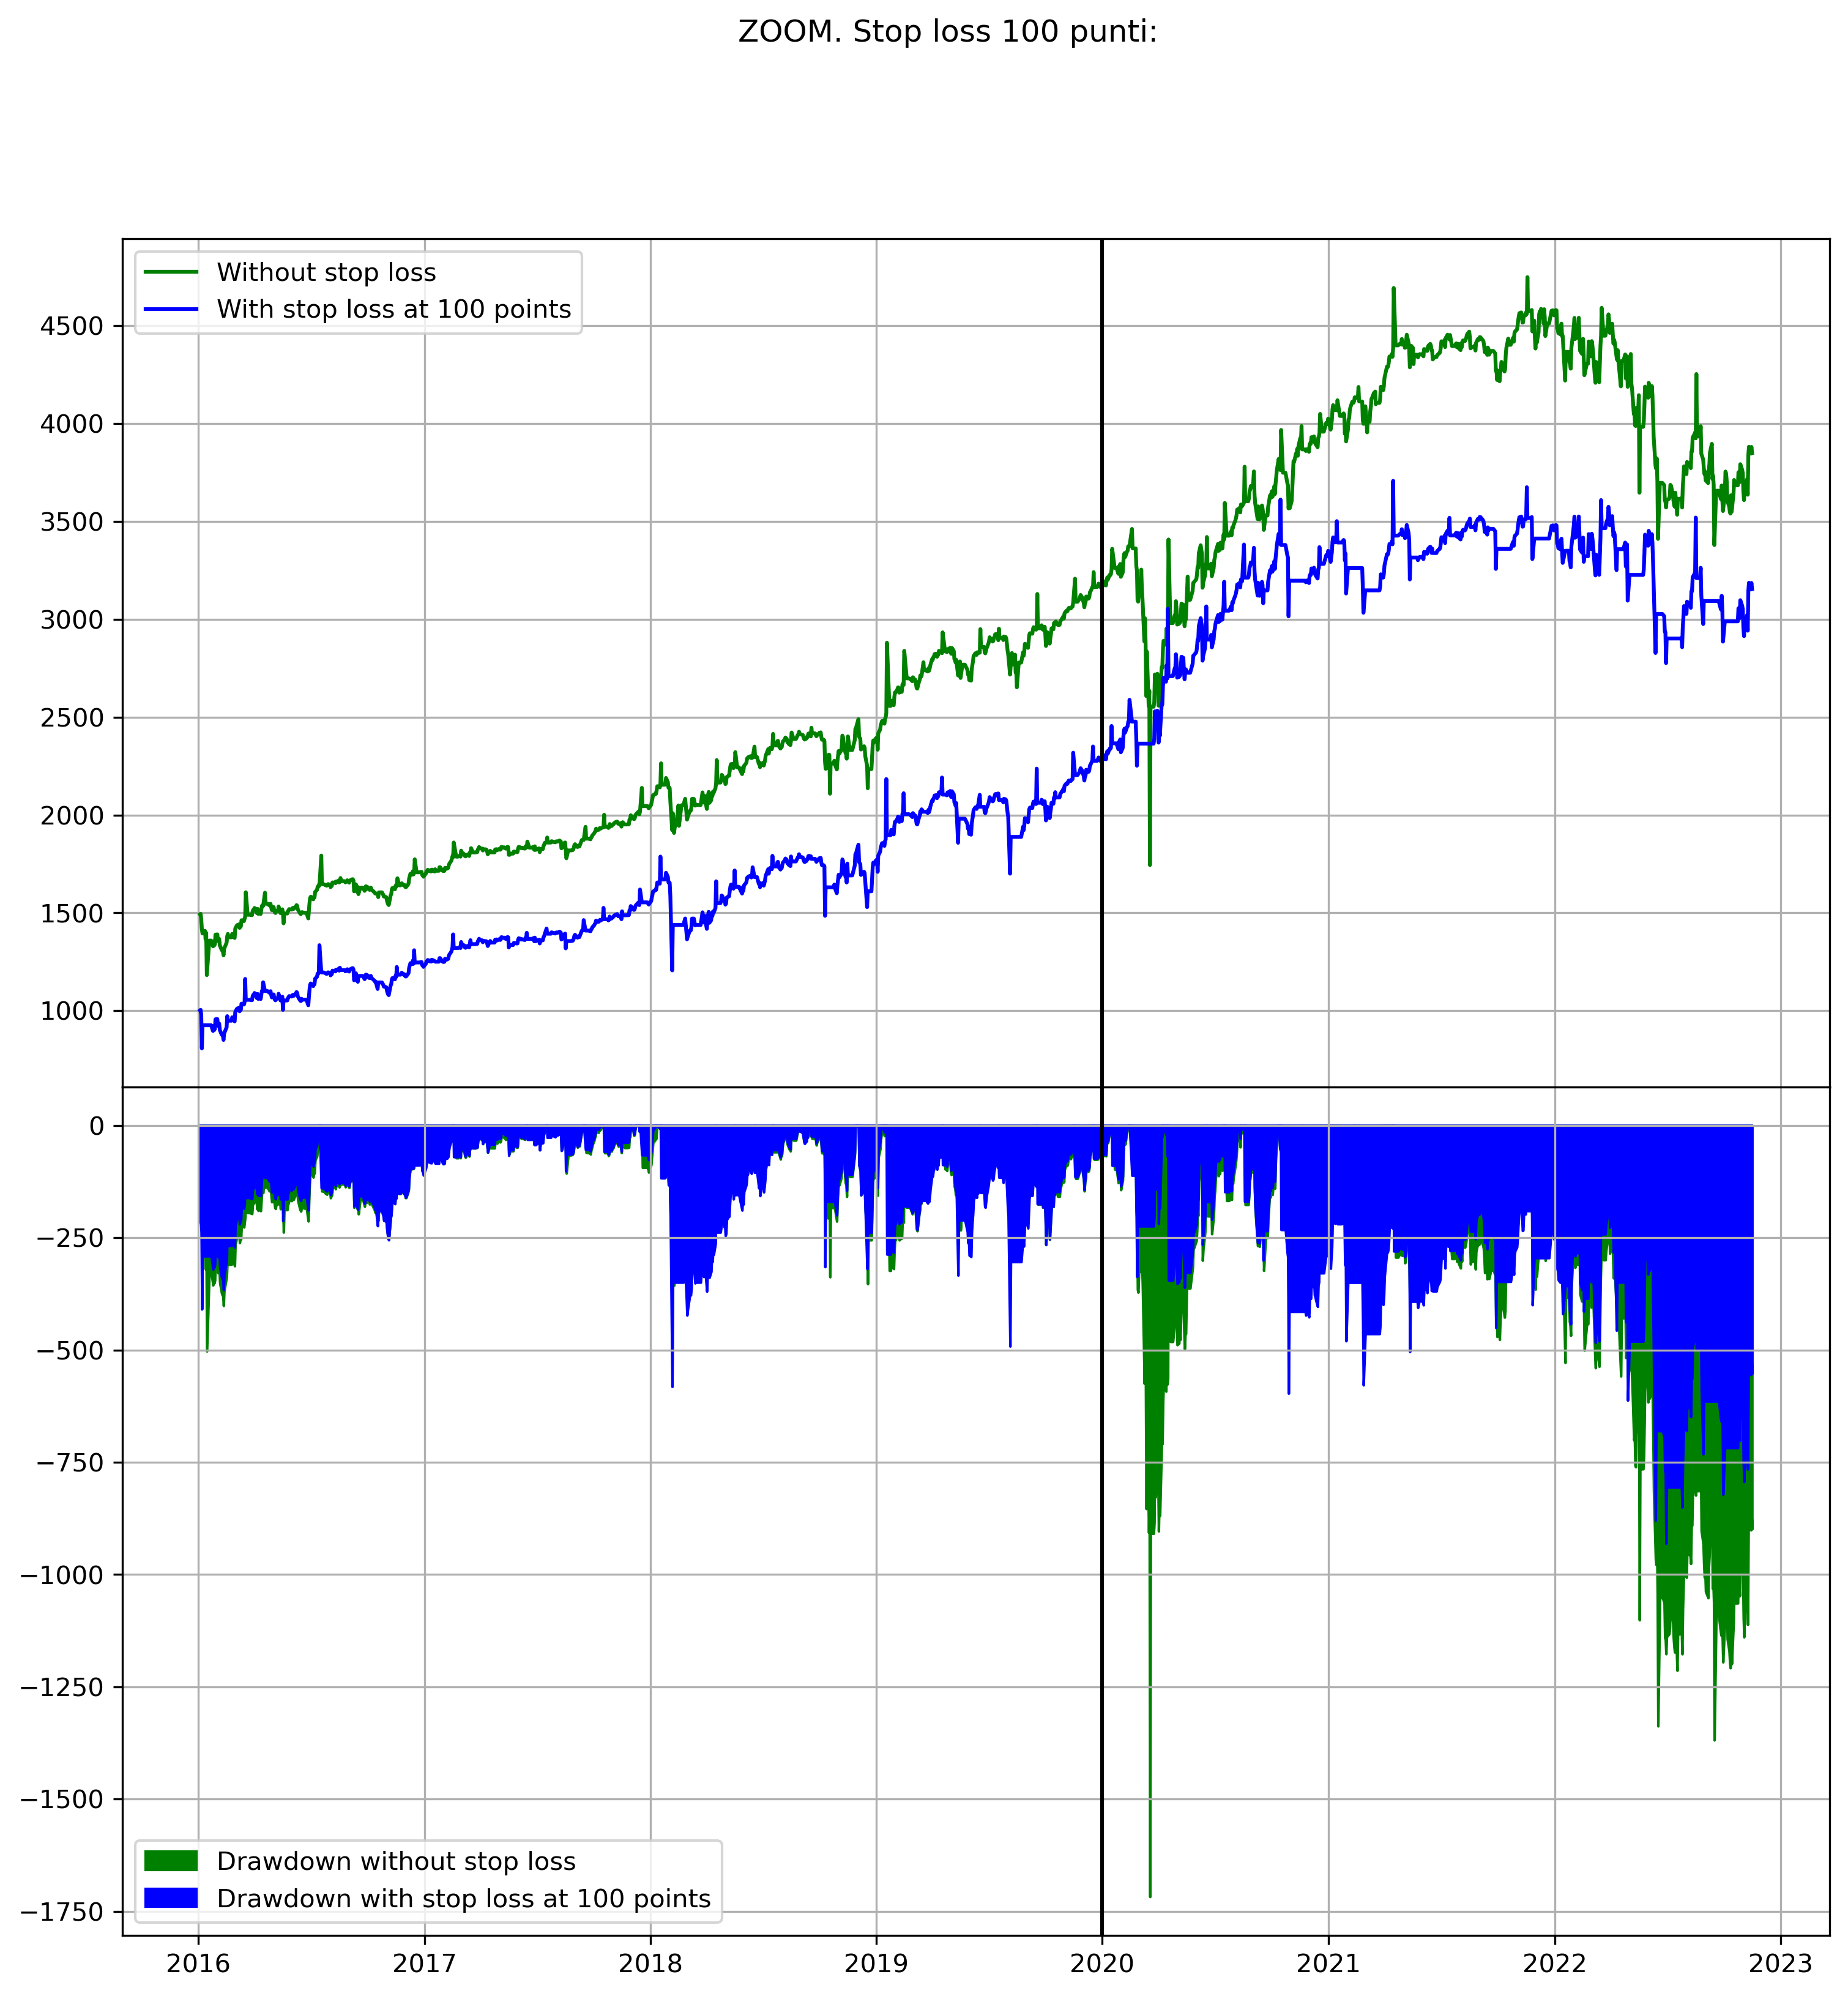

In [64]:
limits=backtest.index.year >=2016

fig, ax = plt.subplots(2, figsize=(12, 12), dpi=300, sharex=True)
fig.suptitle("ZOOM. Stop loss "+str(max_dd_in_point)+" punti:")
ax[0].plot(backtest[limits]["Open_equity"], color="green")
ax[0].plot(backtest[limits]["Real_open_equity"], color="blue")
ax[0].axvline(dt.datetime(2020,1,1),color="black")
ax[0].legend(["Without stop loss","With stop loss at "+str(max_dd_in_point)+" points"])
ax[0].grid()


ax[1].fill_between(backtest[limits].index, 0, -backtest[limits].Open_dd, color="green")

ax[1].fill_between(backtest[limits].index, 0, -backtest[limits].Real_open_dd, color="blue")

ax[1].axvline(dt.datetime(2020,1,1),color="black")
ax[1].legend(["Drawdown without stop loss","Drawdown with stop loss at "+str(max_dd_in_point)+" points"], loc="lower left")
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)

In [65]:
print("Statistiche strategia dal 2000 al 2022:")
statistiche_strategia(backtest)

Statistiche strategia dal 2000 al 2022:

Final equity: 2989.69 points

Number of trades: 265

Number of winning trades: 166
Average profit of winning trades: 53.53 points

Number of losing trades: 99
Average loss of losing trades: -59.55 points

Average profit per trade: 11.28 points

Probability of profit: 63%

Max drawdown:  931.0 points




## Short strategy with stop level

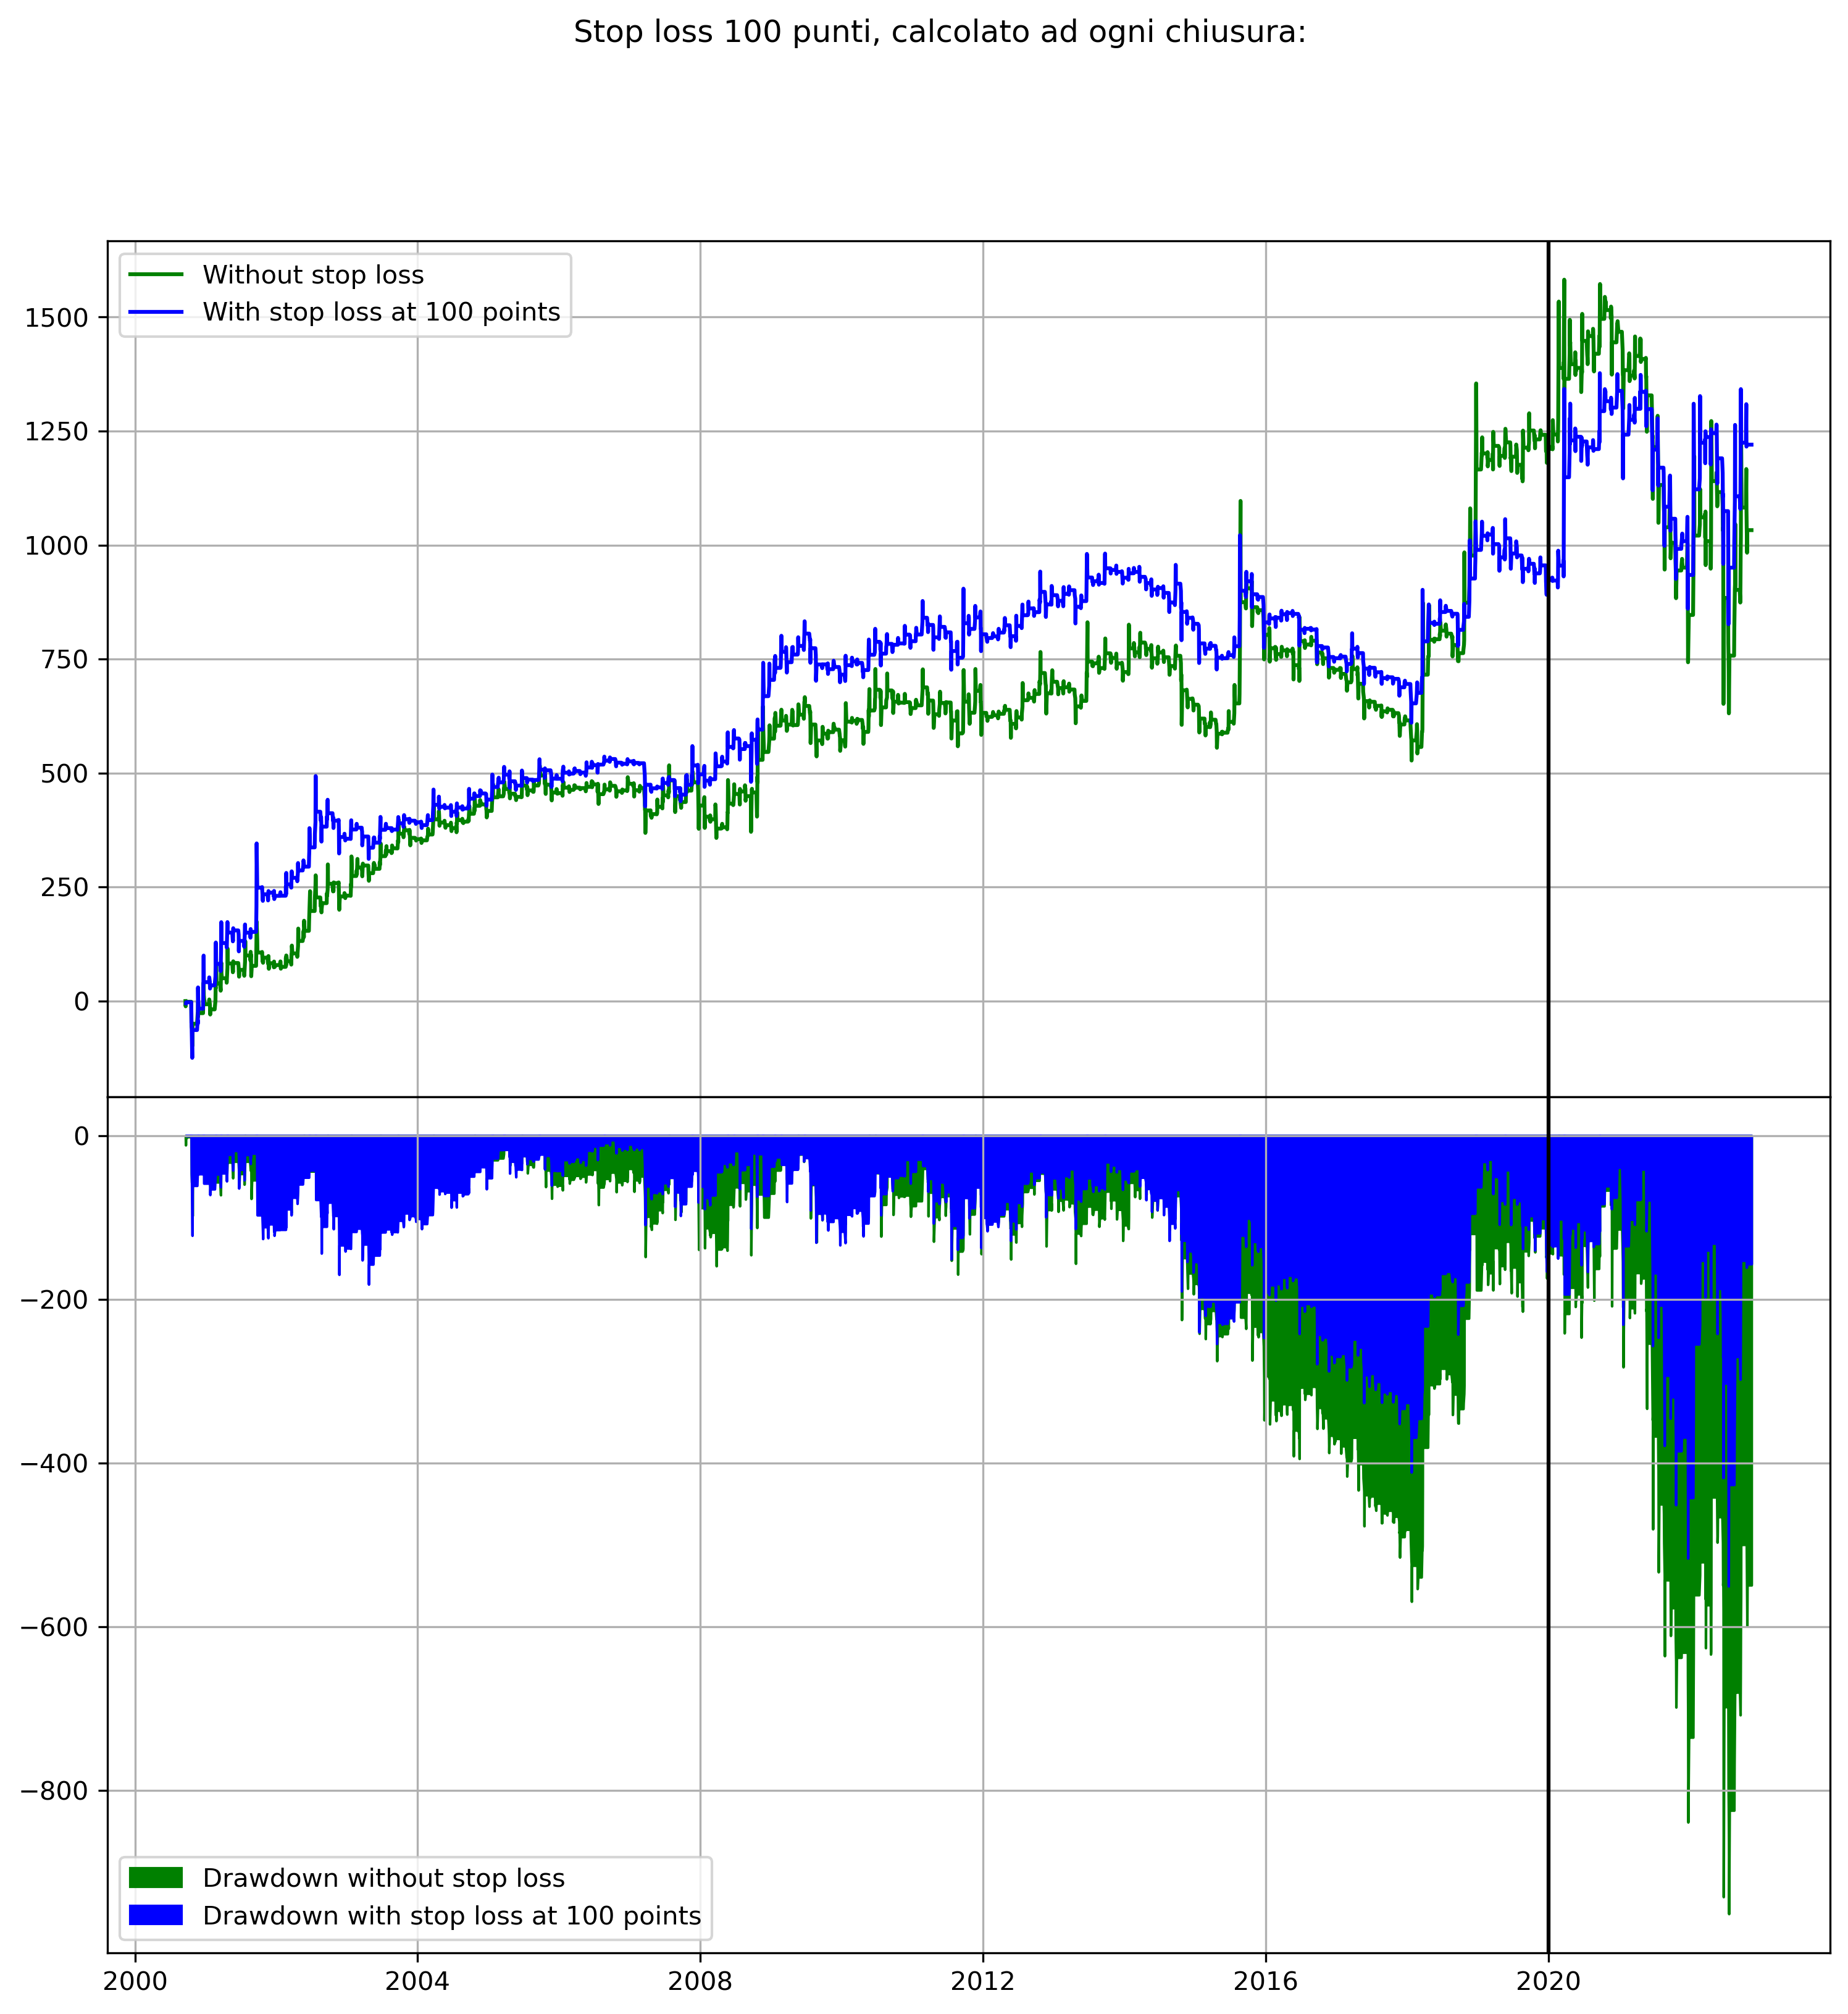

In [66]:
backtest = pd.DataFrame(dataset[dataset.index.year <= 12019].copy())

max_dd_in_point = 100

backtest["Mp"] = (backtest.index.day >= 19) & (backtest.index.day <= 24)
backtest["Mp"] = backtest["Mp"].apply(lambda x: int(x))
backtest["Entry_price"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), backtest.Open, np.nan)
backtest.Entry_price = backtest.Entry_price.fillna(method="ffill")
backtest["Open_operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==0), 
                                       - (backtest.Close - backtest.Open),
                                       np.where((backtest.Mp == 1) & (backtest.Mp.shift(1)==1),
                                       - (backtest.Close - backtest.Entry_price), 0))
backtest["Operations"] = np.where((backtest.Mp == 1) & (backtest.Mp.shift(-1)==0), 
                                  backtest.Open_operations, 0)
backtest["Closed_equity"] = backtest.Operations.cumsum().fillna(method="ffill")
backtest["Open_equity"] = backtest.Closed_equity + backtest.Open_operations
backtest["Open_dd"] = backtest["Open_equity"].expanding().max() - backtest["Open_equity"]
backtest["Closed_dd"]= backtest["Closed_equity"].expanding().max() - backtest["Closed_equity"]



real_enter_rules = np.where((backtest.Mp == 1) & (backtest.Mp.shift(1) == 0),1,0)
real_exit_rules = np.where(((backtest.Mp == 1) & (backtest.Mp.shift(-1) == 0))
                                       | ((backtest.Mp == 1) & (backtest.Open_operations.shift(1) < -max_dd_in_point))
                                       , 1, 0)
backtest["Real_mp"]= generate_mp(real_enter_rules, real_exit_rules)
backtest["Real_open_operations"] = np.where((backtest.Real_mp == 1) & (backtest.Real_mp.shift(1)==0), 
                                       - (backtest.Close - backtest.Open),
                                       np.where((backtest.Real_mp == 1) & (backtest.Real_mp.shift(1)==1),
                                       - (backtest.Close - backtest.Entry_price), 0))
backtest["Real_operations"] = np.where((backtest.Real_mp == 1) & (backtest.Real_mp.shift(-1)==0), 
                                  backtest.Real_open_operations, np.nan)
backtest["Real_closed_equity"] = backtest.Real_operations.cumsum().fillna(method="ffill")
backtest["Real_open_equity"] = backtest.Real_closed_equity + backtest.Real_open_operations
backtest["Real_open_dd"] = backtest["Real_open_equity"].expanding().max() - backtest["Real_open_equity"]
backtest["Real_closed_dd"]= backtest["Real_closed_equity"].expanding().max() - backtest["Real_closed_equity"]


fig, ax = plt.subplots(2, figsize=(12, 12), dpi=300, sharex=True)
fig.suptitle("Stop loss "+str(max_dd_in_point)+" punti, calcolato ad ogni chiusura:")
ax[0].plot(backtest["Open_equity"], color="green")
ax[0].plot(backtest["Real_open_equity"], color="blue")
ax[0].axvline(dt.datetime(2020,1,1),color="black")
ax[0].legend(["Without stop loss","With stop loss at "+str(max_dd_in_point)+" points"])
ax[0].grid()


ax[1].fill_between(backtest.index, 0, -backtest.Open_dd, color="green")

ax[1].fill_between(backtest.index, 0, -backtest.Real_open_dd, color="blue")

ax[1].axvline(dt.datetime(2020,1,1),color="black")
ax[1].legend(["Drawdown without stop loss","Drawdown with stop loss at "+str(max_dd_in_point)+" points"], loc="lower left")
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)


In [115]:
statistiche_strategia(backtest)


Final equity: 1222.72 points

Number of trades: 265

Number of winning trades: 140
Average profit of winning trades: 27.59 points

Number of losing trades: 125
Average loss of losing trades: -21.12 points

Average profit per trade: 4.61 points

Probability of profit: 53%

Max drawdown:  550.5 points




# Conclusioni
    Siamo riusciti a dimezzare i dimezzare i drawdown
    La strategia short è comunque troppo poco profittevole e lenta. Quindi la scarterei.